# Calculate $P(\sigma_\mathrm{axi}^P/\sigma_\mathrm{sph}^P \vert q')$ from $P(\sigma_\mathrm{axi}^P/\sigma_\mathrm{sph}^P, q')$

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline
import csv

from copy import deepcopy
from hierarc.Util.distribution_util import PDFSampling
from scipy.interpolate import interp1d

from cycler import cycler
import matplotlib as mpl
clist = ['#04B2D9', '#F2B33D', '#F29966', '#F2441D', '#0486C5']
mpl.rcParams['axes.prop_cycle'] = cycler(color=clist)

import corner

## The $\sigma_\mathrm{axi}^P/\sigma_\mathrm{sph}^P$ versus $q'$ 2d histogram

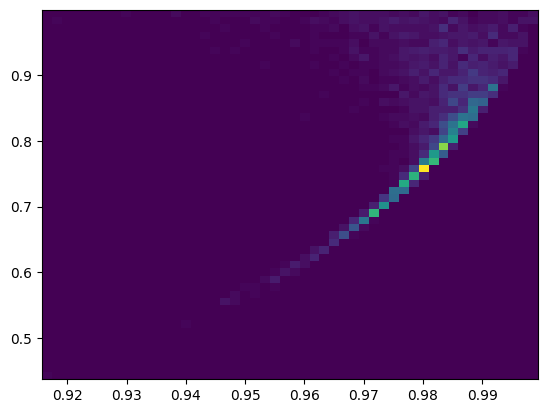

In [2]:
beta_const_list = [-0.2, 0, 0.2]

data_oblate = [np.load('./beta_{}_oblate.npy' .format(i)) for i in range(len(beta_const_list))]

data_prolate = [np.load('./beta_{}_prolate.npy'.format(i)) for i in range(len(beta_const_list))]

for data in data_prolate:
    data[3] = 1/data[3]
    data[4] = 1/data[4]

# when beta = 0

data_oblate = data_oblate[0]
data_prolate = data_prolate[0]

plt.hist2d(data_oblate[0]/data_oblate[1], data_oblate[-1], bins = 50)
plt.show()

### $P(\sigma_\mathrm{axi}^P/\sigma_\mathrm{sph}^P \vert q')$

In [3]:
def correction_cond_q_proj(qobs, ratio_axi2sph, qobs_model, bins_qobs, plot = True):
    counts, bins = np.histogram(qobs_model, bins = bins_qobs)
    bin_ind = np.digitize(qobs, bins) - 1
    bin_min, bin_max = bins[bin_ind], bins[bin_ind+1]
    real_ind = (qobs_model >= bin_min) & (qobs_model < bin_max) # retrieve the index of the velocity dispersions within the bin
    ratio_axi2sph_binned = ratio_axi2sph[real_ind]

    if plot:
        plt.hist(ratio_axi2sph_binned, bins = 50)
        plt.show()
    
    return ratio_axi2sph_binned

Oblate and prolate correction plotted seperately

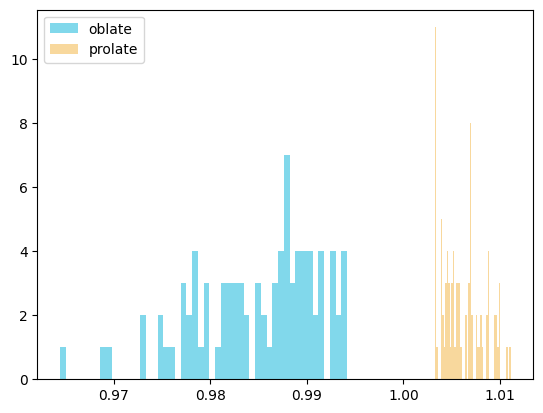

In [4]:
qobs = 0.9

correction_oblate = correction_cond_q_proj(qobs, data_oblate[0]/data_oblate[1], data_oblate[-1], bins_qobs= 50, plot = False)
correction_prolate = correction_cond_q_proj(qobs, data_prolate[0]/data_prolate[1], data_prolate[-1], bins_qobs= 50, plot = False)

plt.hist(correction_oblate, bins = 50, alpha = 0.5, label = 'oblate')
plt.hist(correction_prolate, bins = 50, alpha = 0.5, label = 'prolate')
plt.legend()
plt.show()

## Combine the oblate and prolate correction using the fraction of oblates 

Misalignment angle measured in K24:

In [5]:
obj_names = ['SDSSJ0029-0055', 'SDSSJ0037-0942', 'SDSSJ0330-0020',
       'SDSSJ1112+0826', 'SDSSJ1204+0358', 'SDSSJ1250+0523',
       'SDSSJ1306+0600', 'SDSSJ1402+6321', 'SDSSJ1531-0105',
       'SDSSJ1538+5817', 'SDSSJ1621+3931', 'SDSSJ1627-0053',
       'SDSSJ1630+4520', 'SDSSJ2303+1422']

misalignment = np.array([31. , 28. , 34. ,  3., 14. , 71., 35. , 19.,  9., 19. ,  9. ,
       14.,  5., 12.])

misalignment_err = np.array([30.,  4., 10.,  3., 11.,  7., 13.,  8., 30., 30.,  4., 13.,  9.,
       30.])

In the following we calculate the likelihood of the data as a function of f, where f is the fraction of oblates and 1-f is the fraction of prolates. 

The likelihood function can be written as: 

\begin{equation}
L(\Delta \phi_i \vert f) = \frac{1}{\sqrt{2\pi\sigma^2}} \cdot [f  \exp(-\frac{\Delta \phi_i^2}{2\sigma^2}) + (1 - f) \exp(-\frac{(\Delta \phi_i - 90)^2}{2\sigma^2})],
\end{equation}
for an individual data point.

In [6]:
# use one data point as an example

def LikelihoodIndividual(misalignment, misalignment_err, f_array):
    likelihood_array = np.full_like(f_array, np.nan)
    for i, f in enumerate(f_array):
        likelihood_array[i] = (f * np.exp(-misalignment**2 / 2 / misalignment_err**2) + (1 - f) * np.exp(-(misalignment-90)**2 / 2 / misalignment_err**2)) / np.sqrt(2 * np.pi * misalignment_err**2)
    norm = np.trapz(likelihood_array, f_array)
    likelihood_array = likelihood_array / norm
    return likelihood_array

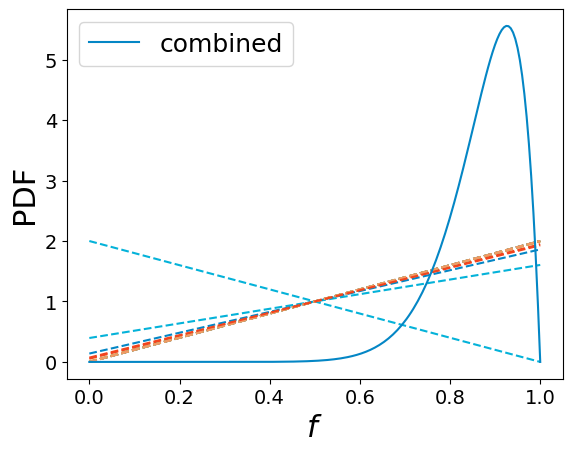

In [7]:
f_array = np.linspace(0, 1, 200)
likelihood_all = []
for i in range(len(misalignment)):
    likelihood_individual = LikelihoodIndividual(misalignment[i], misalignment_err[i], f_array)
    likelihood_all.append(likelihood_individual)
    plt.plot(f_array, likelihood_individual, ls = '--')

likelihood_all = np.array(likelihood_all)
likelihood_combined = np.prod(likelihood_all, axis=0)
norm = np.trapz(likelihood_combined, f_array)
likelihood_combined = likelihood_combined / norm
# plt.axhline(0, ls = ':')
plt.plot(f_array, likelihood_combined, label = 'combined')
plt.xlabel('$f$', size=22)
plt.ylabel('PDF', size=22)
plt.xticks(size=14)
plt.yticks(size=14)
plt.legend(prop={'size': 18})
plt.show()

Calculate the quantile of the PDF of $f$

[0.78826881 0.88476275 0.94802766]


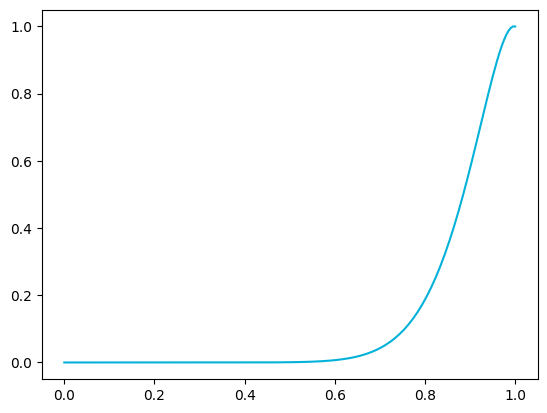

In [8]:
likelihood_combined_cdf = np.cumsum(likelihood_combined * np.diff(f_array)[0]) / np.trapz(likelihood_combined, f_array)
plt.plot(f_array, likelihood_combined_cdf)
# interpolate to obtain the 1 sigma confidence interval
quantile = [0.16, 0.5, 0.84]
cdf_interp = interp1d(likelihood_combined_cdf, f_array)
f_quantile = cdf_interp(quantile)
print(f_quantile)

### Combine the prolate and oblate correction using the a single value $f$

[0.97869219 0.98811374 1.00444977]
[0.97831956 0.98762264 0.99342011]
[0.97821421 0.9870624  0.99179873]


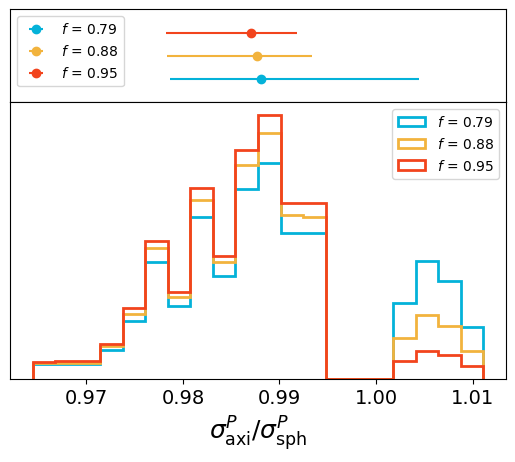

-0.10513400865392875


In [9]:
def correction_combined_single_f(f, correction_oblate, correction_prolate, num_stack = 1):
    
    f_all = np.ones(num_stack) * f
    correction_all = np.array([])
    for f_i in f_all:
        num_draw_from_oblate = round(f_i * (len(correction_oblate) + len(correction_prolate)))
        num_draw_from_prolate = len(correction_oblate) + len(correction_prolate) - num_draw_from_oblate
        try:
            correction_combined = np.concatenate([np.random.choice(correction_oblate, num_draw_from_oblate, replace=True), np.random.choice(correction_prolate, num_draw_from_prolate, replace=True)])
        except:
            correction_combined = np.random.choice(correction_oblate, num_draw_from_oblate + num_draw_from_prolate, replace=True)
        correction_all = np.concatenate([correction_all, correction_combined])


    return correction_all

# fig, axs = plt.subplots(1, 3, figsize=(14, 3))
fig = plt.figure()
gs = fig.add_gridspec(2, 1, hspace=0., height_ratios=[1, 3])
axs = gs.subplots(sharex='col')
axs = axs.flatten()

color_list = [clist[0], clist[1], clist[3]]
quantile_list = []

for i, f in enumerate(f_quantile):

    correction_combined = correction_combined_single_f(f, correction_oblate, correction_prolate, num_stack=1000)

    axs[1].hist(correction_combined, bins = 20, density = True, label = r'$f$ = {:.2f}'.format(f), color=color_list[i], histtype='step', lw=2)
    axs[1].legend()
    axs[1].get_yaxis().set_ticks([])
    # axs[1].set_ylabel('PDF', size=20)
    axs[1].set_xlabel(r"$\sigma_\mathrm{axi}^P/\sigma_\mathrm{sph}^P$", size = 18)
    axs[1].tick_params(axis='x', which='major', labelsize=14)

    quantile = np.quantile(correction_combined, [0.16, 0.5, 0.84])
    print(quantile)
    quantile_list.append(quantile)
    axs[0].errorbar(quantile[1], i, xerr = [[quantile[1] - quantile[0]], [quantile[2] - quantile[1]]], fmt = 'o', color=color_list[i], label = r'$f$ = {:.2f}'.format(f))
    axs[0].set_ylim(-1, 3)
    axs[0].legend(loc='upper left')
    axs[0].get_yaxis().set_ticks([])
    
plt.savefig('../plots/correction_085_oblate_fraction.pdf', bbox_inches='tight', dpi=300)
plt.show()
print((quantile_list[2][1] - quantile_list[0][1]) * 100)


### Combine the prolate and oblate fraction marginalizing over $f$

We first draw randomly from the PDF of $f$, then we use them to combine the oblate and prolate correction.

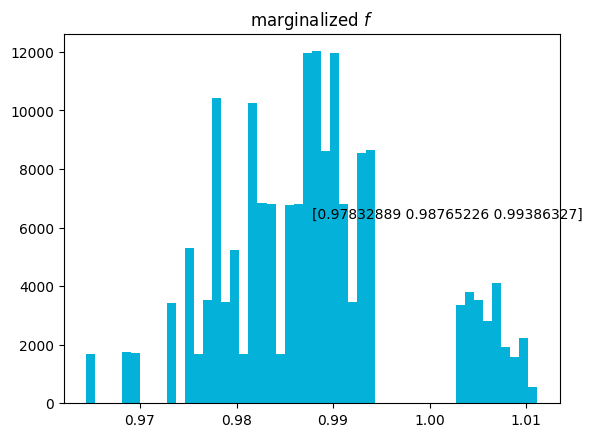

In [10]:
def DrawFromPDF(x_pdf, y_pdf, num):
    cdf = np.cumsum(y_pdf) / np.cumsum(y_pdf)[-1]
    inv_cdf = interp1d(x=cdf, y=x_pdf, fill_value='extrapolate')
    random_num = np.random.uniform(0, 1, num)
    var_rm = inv_cdf(random_num)

    return var_rm

f_draw = DrawFromPDF(f_array, likelihood_combined, 1000)
f_draw = np.sort(f_draw)

def correction_combined_marginalize_f(f_array, correction_oblate, correction_prolate):
    correction_combined = np.array([])
    for f in f_array:
        correction_combined = np.concatenate([correction_combined, correction_combined_single_f(f, correction_oblate, correction_prolate)])
    return correction_combined

correction_combined_fmarginalized = correction_combined_marginalize_f(f_draw, correction_oblate, correction_prolate)
    
plt.hist(correction_combined_fmarginalized, bins = 50)
plt.title('marginalized $f$')
plt.text(0.5, 0.5, np.quantile(correction_combined_fmarginalized, [0.16, 0.5, 0.84]), transform=plt.gca().transAxes)
plt.show()